<h1 style="color:red;">IMBD Critique Data Collector</h1>

### For K.U. business school project : which try to address gap between critics' score and popular success
#### Dataset :
- title | USgross box office revenue | statscore | critic metascores | critic review texts |  
- Dataset : [title, US box office revenue, starscore, [(metascores, metatext),(metascores, metatext),(metascores, metatext)...]]

## STEP1. Import all required modules

In [1]:
# Import modules 
import bs4
import urllib3
import selenium.webdriver as webdriver
# !!!! 커스텀 설정 !!!! 너의 크롬 드라이버 파일의 디렉토리
from time import sleep
from lxml import html
import urllib3
import csv
import os
# Get html text and let lxml parse it in its own way.
http = urllib3.PoolManager()

## STEP2. Store all action movie titles' urls to a variable (bs4, selenium)
```whole_title_urls_storage```

In [3]:
# load action genre page
driver = webdriver.Chrome('/Users/sucky/Desktop/chromedriver') 
#action_genre_url = "https://www.imdb.com/search/title?pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=cd28805a-4e91-4f0f-b066-0db5ff4dd1a7&pf_rd_r=30AH67YYPH64GCS9CRA9&pf_rd_s=right-6&pf_rd_t=15506&pf_rd_i=boxoffice&ref_=chtbo_gnr_1&genres=action&explore=title_type,genres"
action_genre_url = 'https://www.imdb.com/search/title?title_type=movie&genres=action&sort=boxoffice_gross_us,desc&explore=title_type,genres'
driver.get(action_genre_url)
driver.implicitly_wait(3)

#Save all the link at issue
#1). save all the url links of 253,049 action movies.
whole_title_urls_storage = [] # from
 
#2). iterate with selenium to collect all the links

for i in range(3): # !!! CUSTOM SETTING !!! : depends on how many movies you want to crawl. (50movies per 1 page)
    try :
    #wait loading
        driver.implicitly_wait(2)
    
    #get driver's url
        now_url = driver.current_url
        r = http.request('GET', now_url)
        source = r.data
        tree = html.document_fromstring(source)
    
    # get all the href links
        one_page_url_list = ['https://www.imdb.com'+i.get('href') for i in tree.cssselect('div div div div div div div div div h3 a')]
    
    # extend this to whole title urls storage
        whole_title_urls_storage.extend(one_page_url_list)
    
    # click move on to next page
        if now_url == action_genre_url:
            driver.find_element_by_xpath('//*[@id="main"]/div/div[4]/a').click()
        else:
            driver.find_element_by_xpath('//*[@id="main"]/div/div[4]/a[2]').click()
        
    except:
        print('error occured at {}th set'.format(i+202))

# Speak out when finished.
os.system('say "your program has been completed."')

0

### step2. - 2) check data size / check if there are any overlap

In [5]:
print(len(set(whole_title_urls_storage))) #내가 모은 url이 중복없이 원하는 개수대로 모였는지 확인

150


## STEP3. Iterate every url => filter non-movie => access to link to seperate critics' reveiw website => scrape all metascores and matching revies

In [8]:
# Open .csv file
f = open('IMBD_dataset.csv', 'w') # !!!! 커스텀 설정 !!!! : 원하는 '디렉터리/파일명.csv'을 첫번째 인풋에.
wr = csv.writer(f)

# count(url's index)
iter = 0

# Iterate over collected links
for l in whole_title_urls_storage[0:10]:
    
    # index counter (starts from 1)
    iter += 1
    print(iter)
    
    # repeat this
    try:
       
        # <Get html and parsed tree>
            # get html of the link
        r = http.request('GET', l) # l is one link from loop
        source = r.data
        
            # parse them into lxml tree
        tree = html.document_fromstring(source) 
        
        # <Filtering out, non-existent url, years > 2018, non-movie)  
        
        # 2). pre save indicator
        #year_elem = tree.cssselect('div div div div div h1 span#titleYear')
        
            # 1). non-movie filter!
        if ('Gross USA:' not in source): #or (len(year_elem) == 0) or (int([k for k in [i.text_content() for i in year_elem]][0].strip('()')) > 2018)
            print('{} non-movie'.format(iter))
            continue
            
        #if len(year_elem) == 0 :
        #    print('{} no year info'.format(iter))
        #    continue
        
        #if int([k for k in [i.text_content() for i in year_elem]][0].strip('()')) > 2018:
        #    print('loss at {} error while year comparison'.format(iter))
        #    continue
            
        # <Get infoS>
            # find a movie name => 'title'
        title_str = [i.text_content().encode('utf-8') for i in tree.cssselect('div div div div div h1')][0]
        title = title_str.split('\xc2')[0]
            # find a movie star score => 'score'
        score = float([i.text_content() for i in tree.cssselect('div div div div div div strong span')][0])
            # find a us_gross_box_office_revenue => 'us_gross'
        gross_str = [i.text_content() for i in tree.cssselect('#main_bottom div#titleDetails.article')][0].encode('utf-8')
        us_gross = int([i for i in gross_str.split('\n') if i.startswith('Gross USA:')][0].split('$')[-1].replace(',',''))
        
        # Get metalink
        # Get html of the metalink
        # find /~~? part to to use as a key into review page.
        # integrate the found ~~ part with 
        # f'https://www.metacritic.com/movie/{john-wick}/critic-reviews' and get that url html
        # case : 1. data exist : crawl
        
        # find the piece
        first_piece = [link[2] for link in tree.cssselect('div div div div.titleReviewBarSubItem div a')[0].iterlinks()][0]
        
        # make 2nd url of l (now link)
        new_list = l.split('/')[:-1]
        new_list.append(first_piece)
        second_url = '/'.join(new_list)
        
        # get html of 2nd url
        r = http.request('GET', second_url)
        source = r.data
        # and parse it
        tree = html.document_fromstring(source)
        # get /~? => matacritic's title from it.
        clue_string = [i for i in tree.cssselect('div div.see-more')[0].iterlinks()][0][2].split('?')[0].split('/')[-1]
        # get 3rd url out of clue string
        all_review_url = 'https://www.metacritic.com/movie/{}/critic-reviews'.format(clue_string)
        
        #<in the all_review_url> - make a list of scores and a list of texts.
        #    get html of all_review_url
        r = http.request('GET', all_review_url)
        source = r.data
        tree = html.document_fromstring(source)
        
        #     get a list of critic scores
        lists_of_each_text_list = []
        list_of_critic_scores = []

        for i in tree.cssselect('div.left.fl'):
            lists_of_each_text_list.append(i.text_content())

        for k in range(len(lists_of_each_text_list)):
            list_of_critic_scores.append(int(lists_of_each_text_list[k].split('\n')[4]))
        #<list_of_critic_scores> completed!!
        
        #     get a list of critic texts
        a_movie_critic_texts_list = []
        for j in tree.cssselect('div div div div div div div div a.no_hover'):
            a_critic_text = j.text_content().strip().encode('utf-8')
            a_movie_critic_texts_list.append(a_critic_text)
    
        #<a_movie_critic_texts_list> completed
        
        #write line by line into csv file
        
        for c in range(len(list_of_critic_scores)):
            wr.writerow([title, score, us_gross,list_of_critic_scores[c],a_movie_critic_texts_list[c]])
            
    # if it's another case!        
    except Exception as e:
        print("unknown error at url index {}".format(iter)) # ignore if there are already so many data.
        continue
        
# Close csv.file
f.close()

# Tell me
os.system('say "your program has been completed."')

1
2
unknown error at url index 2
3
4
5
6
7
8
9
unknown error at url index 9
10
unknown error at url index 10


0

# Done! Data collected into 'IMBD_dataset.csv' in my current directory.

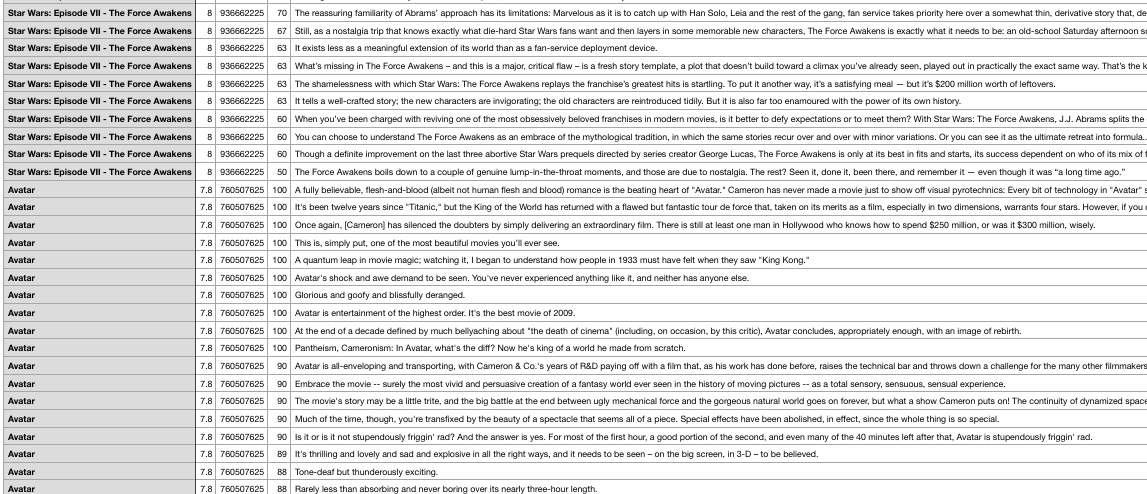